# How Data Clustering Works

**Note: Clustering is typically an unsupervised (no labels) activity. A similar task could be supervised classification or you could learn decision making boundaries bweteen classes of objects with supervised regression.**

In this notebook we will review some of the various clustering methods from both traditional Machine Learning (ML). There are large numbers of clustering algorithms available and we will go into detail on some of the ones used in the large citizen science platform 'Zooniverse's' data aggregation code. To provide a comprehensive review of the topic, we will begin by covering some of the theory behind data clustering along side some worked examples.  Specifically we will be covering how DBSCAN, OPTICS, and HDBSCAN work, when each should be used, and the various parameters that each of them provide.

## What problem does clustering solve?

At the most basic level, clustering is the process of taking a set of data (e.g. a list of numbers, points drawn on an image, etc...), finding groups of the data that are "similar," and assigning a label to each group.  Once each group is found, an average is used (or a generalization of the average as seen later on) to represent the group with a single value, and the variance about that average is used to define the extent of the group.

### What does it mean to be "similar?"

Two data points are similar if they are close together under some definition of "distance" called a **metric**.  Examples of common metrics are:
- Euclidean distance (i.e. straight line distance)
- Manhattan distance (i.e. you can only move on a fixed grid)
- Jaccard distance (i.e. percent overlap of shapes)
- Most anything you can quantify (e.g. things similar in color, the "roundness" of a shape)
- A combination of multiple metrics

#### Mathematical side note
Mathematically a metric must satisfy three conditions
1. A point always has a distance of zero with itself and any two points with a distance of zero are the same point
2. Distances are symmetric between any two points
3. Distances follow the triangle inequality

See https://en.wikipedia.org/wiki/Metric_(mathematics) for more a detailed definition

### Scikit-learn (sklearn) resources
[This webpage](https://scikit-learn.org/stable/modules/clustering.html) has an excellent overview of the clustering algorithms avalible for use 'out the box' in sklearn. An image taken from this site which nicely demonstrates differences in clustering algorithms is shown below.

![cluster_comparison_sklearn](https://github.com/reac2/UKSA_SoftwareDataAI_Training/blob/main/UKSA_SoftwareDataAI_Training/Phase2_Materials/static_images/cluster_comparison_sklearn.png?raw=true)

On [this webpage](https://scikit-learn.org/stable/modules/clustering.html) you will also find an excellent resource for quickly identifying potentially useful clustering algorithms for your own data. Specifically a quick-look table provides: 'Method name', 'Parameters' (your input), 'Scalability' (algorithmis efficiency for large datasets or many clusters), 'Usecase', and 'Geometry' (the metric used).

### We have distances, now what?

To turn these distances into clusters there are typically two ways to go about it:
- If you know how many cluster there are in the data
  - Find the optimal way to split all the data into N groups such that the pairwise distances between points in each group are as small as possible (e.g. K-means, K-medians, K-centers)
- If you don't know the number of clusters
  - Look for areas in the data with "high density" and assign a group label to each of them (e.g. DBSCAN, OPTICS, HDBSCAN)

For the rest of this notebook we will focus on the second type of clustering since the number of clusters is typically the question Zooinverse projects are trying to answer in the first place.

## Turning density into clusters

In this section we will start diving into to specifics of how DBSCAN, OPTICS, and HDBSCAN work under the hood.  To show this off better we will crete a test set of data we can use for creating visualizations for each step of the process.

Q1. Install hdbscan below.

ERROR: Could not find a version that satisfies the requirement hbdscan (from versions: none)
ERROR: No matching distribution found for hbdscan
Note: you may need to restart the kernel to use updated packages.


Below we will create a 'moons' and 'blobs' datset.

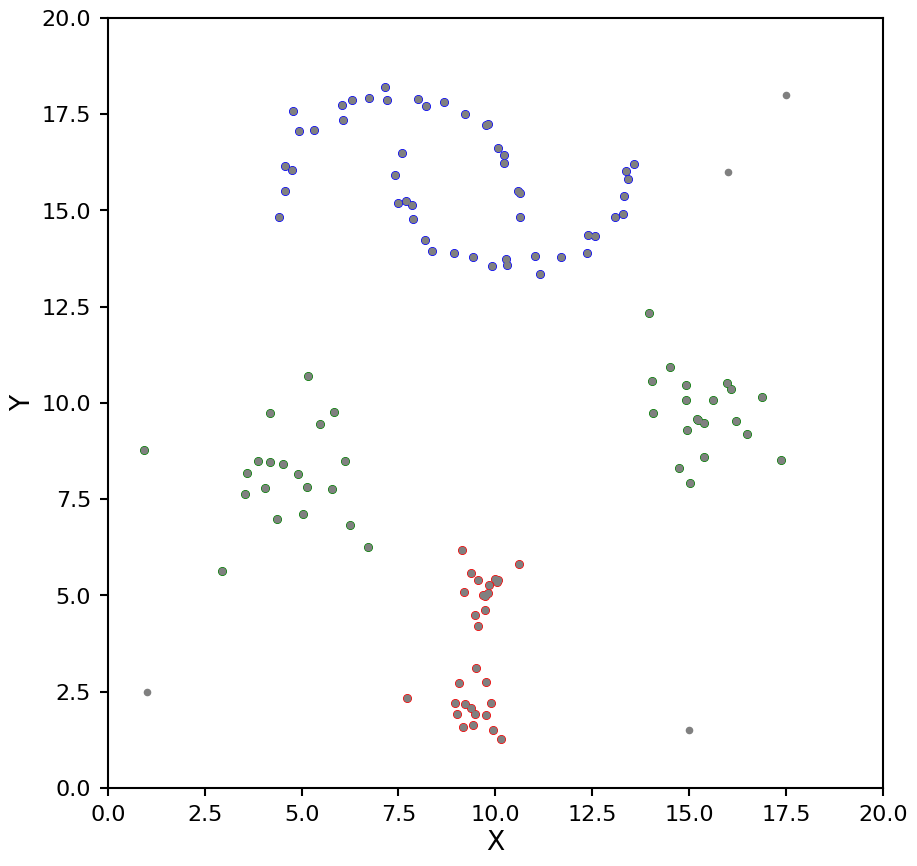

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import hdbscan

from sklearn.cluster import DBSCAN, OPTICS
from sklearn.datasets import make_blobs, make_moons

plt.style.use({
    'font.size': 16.0,
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.5,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 6,
    'xtick.labelsize': 'medium',
    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 6,
    'ytick.labelsize': 'medium',
    'axes.linewidth': 1.5,
    'axes.titlesize': 'x-large',
    'axes.labelsize': 'large',
    'axes.spines.top': True,
    'axes.spines.right': True,
})

# Generate sample data

# Generate some 'blobs'
centers_1 = [[9, 2], [10, 5.2]]
X_blob_1, _ = make_blobs(n_samples=30, centers=centers_1, cluster_std=0.5, random_state=0) # this will be red below

centers_2 = [[4, 8], [16, 10]]
X_blob_2, _ = make_blobs(n_samples=40, centers=centers_2, cluster_std=1.2, random_state=0) # this will be green below

# Generate some nested 'moons' - a common cluster test set
X_moons, _ = make_moons(n_samples=50, noise=0.07, random_state=5) # this will be blue below
# shift the moons data
X_moons[:, 0] = 3 * (X_moons[:, 0] + 2.5)
X_moons[:, 1] = 3 * (X_moons[:, 1] + 5)

X_noise = np.array([
    [16, 16],
    [17.5, 18],
    [1, 2.5],
    [15, 1.5]
]) # Noise we remain grey only below

# stack all data into one array
X = np.vstack([X_blob_1, X_moons, X_blob_2, X_noise]) # here all data is stacked which we will want later

# plot data
plt.figure(figsize=[10, 10])
plt.scatter(X_blob_1[:, 0], X_blob_1[:, 1], s=30, c='r') # red blobs 1
plt.scatter(X_blob_2[:, 0], X_blob_2[:, 1], s=30, c='g') # green blobs 2
plt.scatter(X_moons[:, 0], X_moons[:, 1], s=30, c='b') # blue moons
plt.scatter(X[:, 0], X[:, 1], s=20, c='grey') # stacked in grey - noise will appear grey only
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('X')
plt.ylabel('Y');

A few notes about the test data here:
- We have blobs of different densities
- We have irregular shaped clusters at the top of the image

These properties will help to distinguish between the clustering methods later on

### Density-based spatial clustering of applications with noise (DBSCAN)

Most density clustering algorithms are rooted in DBSCAN, so as a starting point it is useful to understand how DBSCAN works.  This algorithm is a four step process:
1. **Core points** are defined as a group of at least **k** points (also called **min_samples**) that are all mutually within a distance $\epsilon$ (also called **eps**) of each other
2. Each set of **core points** is assigned a cluster ID number
3. Any data point that is within a distance $\epsilon$ of any **core point** is assigned the same cluster ID number as that **core point**
4. All other points are marked a noise

Lets see how this works on the test data:

In [3]:
# define a plotting function that will be reused for DBSCAN plots
def plot_dbscan(db, X):
    '''
    Plot the resutls of DBSCAN

    Parameters
    ----------
    db : The DBSCAN class instance you would like to plot

    X : The data DBSCAN was fit with
    '''
    # make a mask for each core point
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=[10, 10])
    # loop over each unique cluster label
    unique_labels = set(db.labels_)
    for k in unique_labels:
        kdx = db.labels_ == k
        if k == -1:
            # these are the points that don't belong to a cluster
            # plot them as black
            color = 'k'
            plt.scatter(X[kdx, 0], X[kdx, 1], color=color, s=3)
        else:
            # otherwise use the standard color cycle for the points in clusters
            color = f'C{k}'
            core_kdx = kdx & core_samples_mask
            non_core_kdx = kdx & ~core_samples_mask
            # make the core points larger in size
            plt.scatter(X[core_kdx, 0], X[core_kdx, 1], color=color, s=35, edgecolors=color)
            plt.scatter(X[non_core_kdx, 0], X[non_core_kdx, 1], color=color, s=5)

    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('X')
    plt.ylabel('Y');

Q2. Explore and plot dbscan for different parameters of `min_samples` and of `eps`. Try to optimise for the moons, then the blobs, then the full dataset.

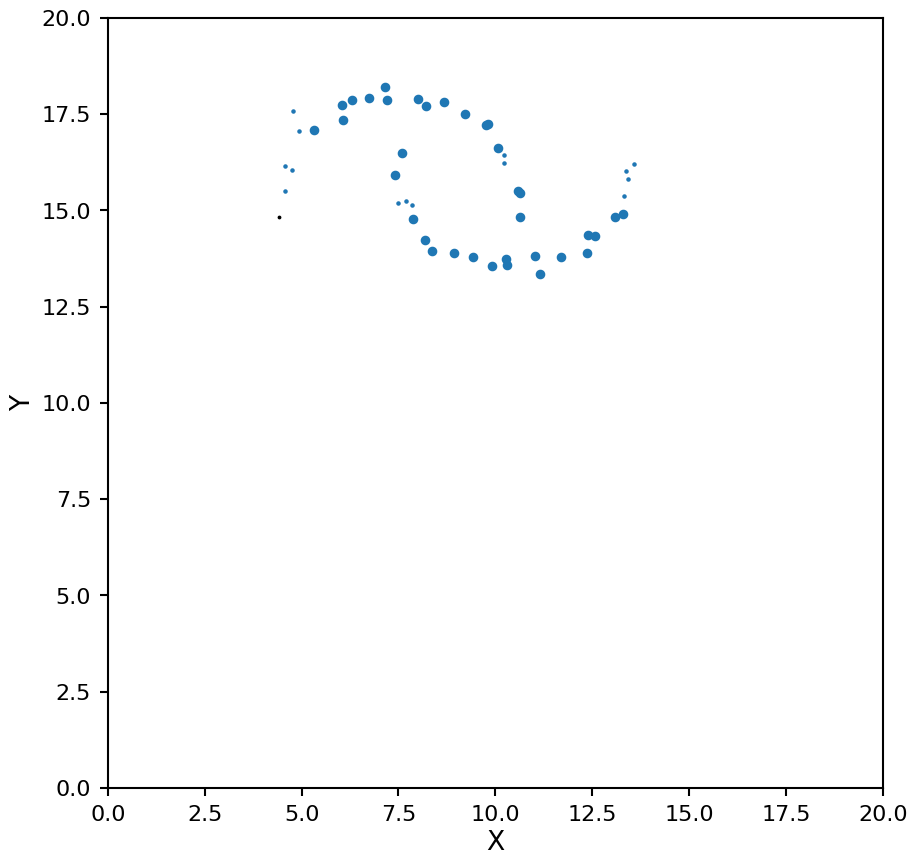

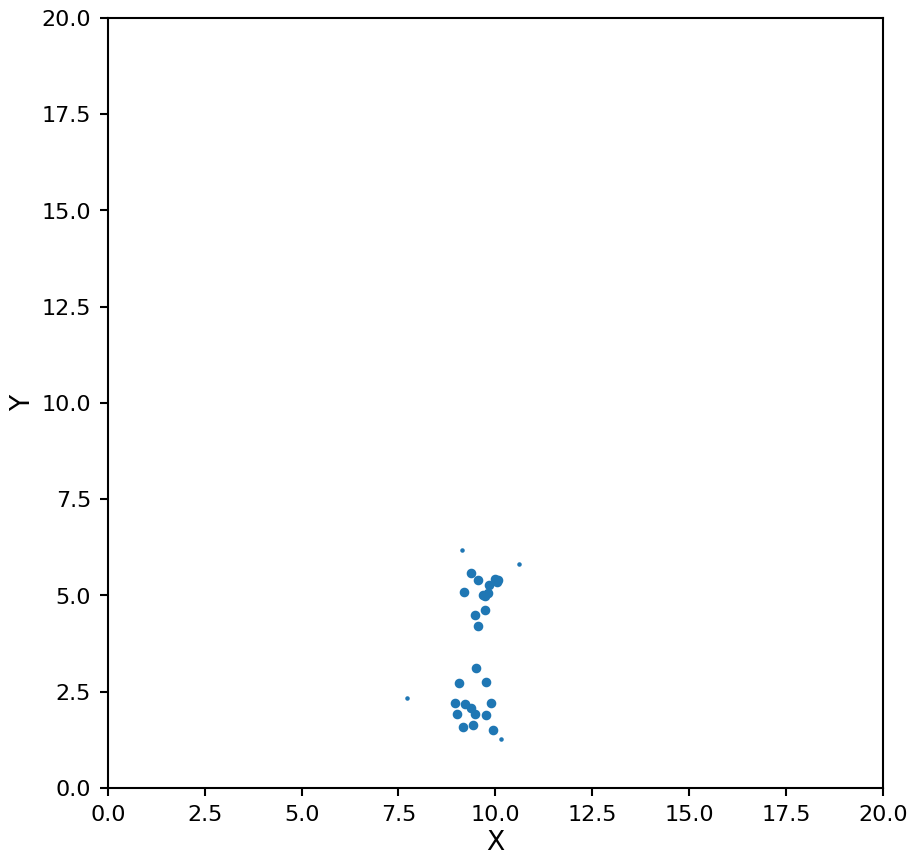

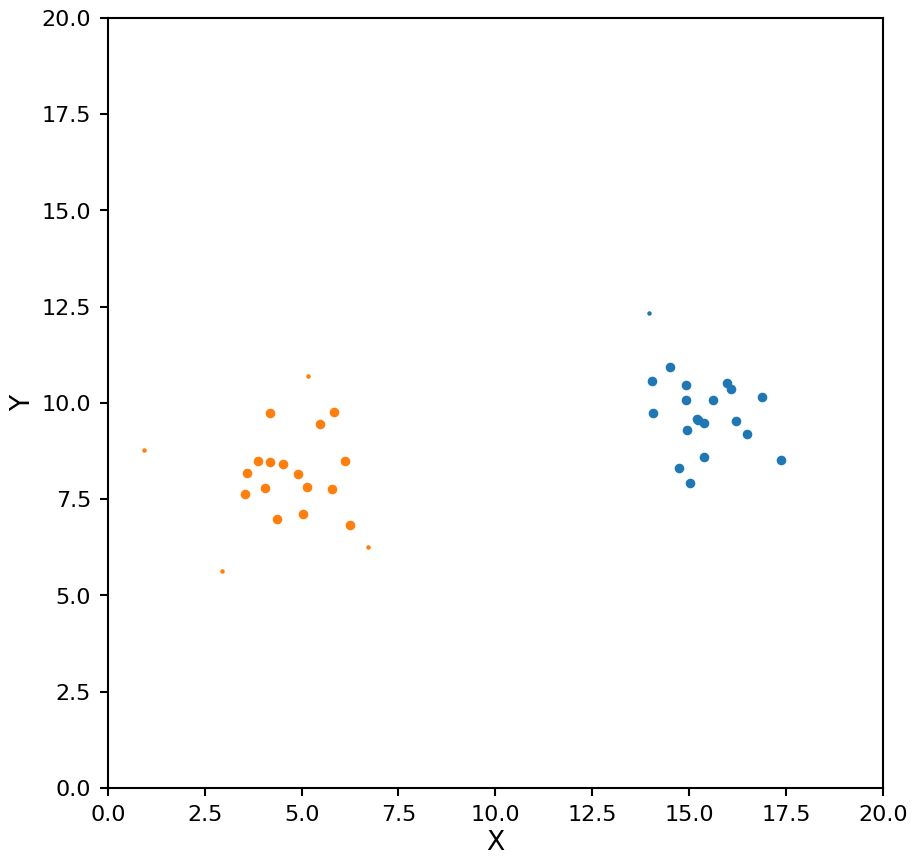

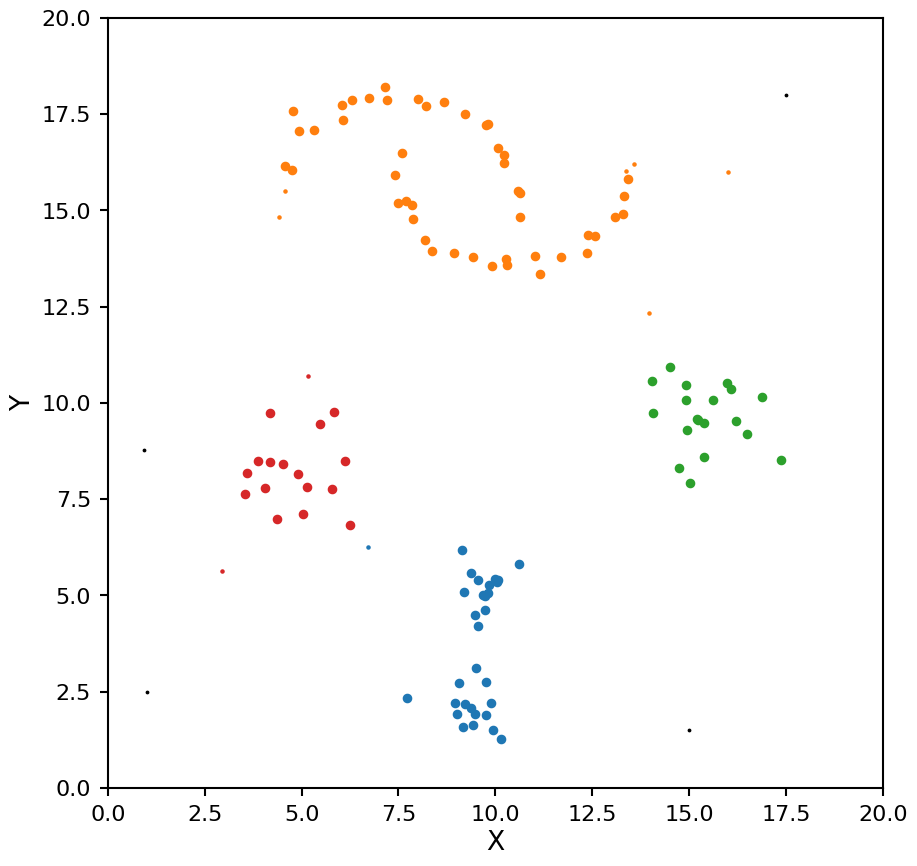

In [44]:
dbMoons = DBSCAN(eps=2, min_samples = 10).fit(X_moons)
dbBlobs1 = DBSCAN(eps=1.25, min_samples = 10).fit(X_blob_1)
dbBlobs2 = DBSCAN(eps=2.75, min_samples = 10).fit(X_blob_2)
dbFull = DBSCAN(eps=2.6, min_samples = 10).fit(X)

plot_dbscan(dbMoons, X_moons)
plot_dbscan(dbBlobs1, X_blob_1)
plot_dbscan(dbBlobs2, X_blob_2)
plot_dbscan(dbFull, X)

#### Pros and cons of DBSCAN
Pros:
- Easy to write down (both in code and description)
- Can be quite fast on larger data sets
- Does not assume a specific shape for the clusters (K-means assumes clusters are gaussian in shape)
- Can detect when all points belong to a single cluster

Cons:
- It assumes all clusters in the data have similar densities
- Finding an appropriate $\epsilon$ value cn be difficult and it only gets harder with higher dimensional data

### Improving on DBSCAN
Since its development, the authors of DBSCAN have gone on to generalize the algorithm and come up with new ways to get around its shortcomings.

This lead to the development of OPTICS (ordering points to identify the clustering structure) and HDBSCAN (hierarchial density-based spatial clustering with noise). To better understand how these two algorithms work (and how they relate to DBSCAN) we will define some common terms and techniques.

## Transforming the metric space
To include density information into the clustering process we need to use a metric that includes this density in its calculation.  To make this new metric easier to understand we will introduce some notation:

- $d(a,b)$: the distance between points $a$ and $b$ using the original metric $d$
- $\mathrm{core}_k(a)$: the **core distance** about the point $a$ defined as the distance between point $a$ and its $k^{th}$ nearest neighbor (this value of $k$ is the **min_samples** from before)

The new metric is called the mutual reachability distance (MRD) and is defined as:

$d_{\mathrm{mreach-k}}(a,b) = \max(\mathrm{core}_k(a), \mathrm{core}_k(b), d(a,b))$

By using this transformation the distance between points in high density areas (with low core distances) are unchanged, and the distance between points in low density areas (high core distances) are increased.

### Note about the mutual reachability distance (MRD)
The above equation is the MRD as defined by HDBSCAN, OPTICS uses a slightly different definition for its MRD.  While the function is different, in the has the same effect on the data points as the equation above, high density points stays the same and low density points are "pushed away".

### Example
Let's take a look at how this new metric transforms the data points in our test set.  **Note, the following code is only for illustrating what this process does, in production this transformation is done by the OPTICS and HDBSCAN internally.**  After finding the MRD we can use multi-dimensional scaling (MDS) to visualize what the points would look like with these new distances.

Q3: Calculate the MRD for each pairwise set of points as a NxN matrix.

In [ ]:
def mrd(db, X):
    for i in range(len(db)):
        a = db[i]
        b = db[i + 1]
        d_ab = (((X[i, 0] - X[i+1, 0])**2)+((X[i, 1] - X[i+1, 1])**2))**0.5
        core_ka = 
        core_kb = 
        MRD = max(core_ka, core_kb, d_ab)

Q4: Using this distance matrix, use multi-dimensional scaling (`sklearn.manifold.MSD`) to create a set of points in 2D space that follow this new distrance matrix.

In [ ]:
from sklearn import manifold

manifold.MDS()

## Minimum spanning tree and Reachability plot
Now that we have the MRD matrix we can use that data to create a minimum spanning tree.  This is a process of connecting every data point in the set to at least one other point such that the sum of MRD values for each connection is minimized across the entire data set.  Doing this provides a way to order the data points.

Q5: Use `scipy.sparse.csgraph.minimum_spanning_tree` to recreate the `MST.png` plot (uploaded with the notebook) with each point in the tree connected by a colored line representing the MRD value of that link.

Starting from the minimum spanning tree, we can create a reachability plot to better understand the data's structure.  This plots the MRD for each point in the tree ordered by how the tree connects the points.

For simplicity we will use the minimum spanning tree as calculated by the OPTICS class.  This can be accessed with the `reachability_` and `ordering_` methods after fitting to data.

In [ ]:
# for consistency with the next section we will use OPTICS to make the spanning tree this time
opt = OPTICS(min_samples=5)
opt.fit(X)

space = np.arange(X.shape[0])
reachability = opt.reachability_[opt.ordering_]

plt.figure(figsize=[10, 4])
plt.step(space, reachability)
plt.xlabel('Index')
plt.ylabel('MRD')
plt.title('Reachability Plot');

From the plot we can start to see a distinct "U" pattern caused by the clustered nature of the data.  When you pass from one cluster to the next the MRD value will increase rapidly, but when you are within a cluster it stays more consistent.  

### DBSCAN again
All of this work now gives us a second way to compute clusters for DBSCAN.  Drawing horizontal lines at the desired $\epsilon$ value and taking all continuous groups of points below the line to be a single cluster gives us back the DBSCAN results from before!  Here is the reachability plot again with the $\epsilon$ values from above:

Q6: Place horizontal lines at each of the `eps` vlues you used in Q2.  Can you see why there is no one value of `eps` that can find every cluster?

### OPTICS to the rescue

OPTICS looks at the the slope from one point to the next on this plot and if it passes a threshold value $\xi$ (called **xi** in the code) a cluster boundary is drawn.  In essence this looks for the distinct "U" shape clusters make on this plot.  Specifically, cluster boundaries are drawn if the ratio from one point to its successor on the reachability plot is more than $1 - \xi$.

In general you are better off keeping $\xi$ at its default value of 0.05 and instead adjust **min_samples** and **min_cluster_size** (each cluster is grown until it has at least this many points) as it will have a more meaningful effect on the resulting clusters.

Time to look at some examples:

In [ ]:
# defind a plotting function that will be reused for OPTICS plots

def plot_optics(opt, X):
    '''
    Plot the resutls of OPTICS

    Parameters
    ----------
    opt : The OPTICS class instance you would like to plot

    X : The data OPTICS was fit with
    '''
    space = np.arange(X.shape[0])
    reachability = opt.reachability_[opt.ordering_]

    fig = plt.figure(figsize=(8, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=(1, 4), hspace=0.12)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    unique_labels = set(opt.labels_)
    labels = opt.labels_[opt.ordering_]
    for k in unique_labels:
        kdx1 = labels == k
        kdx2 = opt.labels_ == k
        if k == -1:
            # these are the noise points
            color = 'k'
            s=3

        else:
            color = f'C{k}'
            s=15
        ax2.scatter(X[kdx2, 0], X[kdx2, 1], color=color, s=s)
        ax1.scatter(space[kdx1], reachability[kdx1], color=color, s=s)

    ax2.set_xlim(0, 20)
    ax2.set_ylim(0, 20)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y');

Q7: Adjust the values of `min_samples` and `min_cluster_size` to find values that can identify each cluster.

#### Pros and cons of OPTICS
Pros:
- Does not assume a specific shape for the clusters (K-means assumes clusters are gaussian in shape)
- Can detect when all points belong to a single cluster
- All clusters can be different densities

Cons:
- Not easy to write down (in code or description)
- Can take longer to run and use more memory than DBSCAN or HDBSCAN for large data sets



### HDBSCAN

The steps for HDBSCAN will start simialrly to the other clustering routines;
1. Transform the space according to the density/sparsity. (Mutual reachability distance).
2. Build the minimum spanning tree of the distance weighted graph. (The step we are starting from).
3. Construct a cluster hierarchy of connected components.
4. Condense the cluster hierarchy based on minimum cluster size.
5. Extract the stable clusters from the condensed tree.

So the step we are on now is sorting this minimum spanning tree but creating a hieracry of connected components. A good way to do this is to start this is by sorting the edges of the tree by distance. It does this in increasing order, small distances first and then increase by iterating. But how does it identify cluster edges?

To construct a cluster hieracry HDBSCAN does the follow:

0. Set $\lambda$ to 0
1. Start with all the points in a single cluster
2. Find the largest link in the spanning tree and remove it
3. Count the number of points in each distinct set of linked points, if it is above a threshold value (called **min_cluster_size**) keep the cluster and track the size, if not remove the cluster.
4. Increase $\lambda$ by 1/distance for the link that was cut
5. For each distinct set of linked points repeat steps 1-4, continue until all points are removed

By encoding the number of points in each clusters at each $\lambda$ values as the thickness of of the bar on tree plot we can create what is called the condensed tree plot.  HDBSCAN has a built in tool for creating these kinds of plots.

In [ ]:
hdb = hdbscan.HDBSCAN(min_samples=5, gen_min_span_tree=True)
hdb.fit(X)

plt.figure(figsize=[10, 10])
ax = plt.gca()
hdb.condensed_tree_.plot(axis=ax);

#### Picking out the clusters

Finally, this condensed tree plot can be used to find the most "long lived" clusters by finding the bars on this plot that contain the most "surface area."  (Although it might not look like it, the area of each bar on this plot is directly proportional to the probability of each cluster being the "true" cluster).  This is refereed to as the Excess of Mass (eom) method of selecting clusters.  We can circle these selected clusters by using the **select_clusters** keyword when plotting.

In [ ]:
plt.figure(figsize=[10, 10])
ax = plt.gca()
hdb.condensed_tree_.plot(axis=ax, select_clusters=True);

In [ ]:
# defind a plotting function that will be reused for HDBSCAN plots
def plot_hdbscan(db, X):
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    unique_labels = set(db.labels_)
    for k in unique_labels:
        kdx = db.labels_ == k
        if k == -1:
            # these are the noise points
            color = 'k'
            ax1.scatter(X[kdx, 0], X[kdx, 1], color=color, s=3)
        else:
            color = f'C{k}'
            ax1.scatter(X[kdx, 0], X[kdx, 1], color=color, s=10)

    ax1.set_xlim(0, 20)
    ax1.set_ylim(0, 20)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    db.condensed_tree_.plot(axis=ax2, select_clusters=True)

Q8: Explore different values of `min_samples`, `min_cluster_size`, and `cluster_selection_method` for the `hdbscan.HDBSCAN` function to try and find all the clusters in the data.

### What if there is only one cluster in the data?

This is one case where HDBSCAN does not do so well.  Because of the way the algorithm constructs the condensed tree, the top leaf (representing all the data points belonging to a single cluster) will tend to be picked even when there are clear structures in the data, for this reason it will ignore this case by default.  If you do want to consider all the data belonging to a single cluster as a valid solution you can set the **allow_single_cluster** keyword.  Below we can illustrate this by setting **min_samples** to 9 with **allow_single_cluster** both on and off.

Q9: Use `min_samples=9` and `allow_single_cluster` as both `True` and `False` to see the difference.

#### Pros and cons of HDBSCAN
Pros:
- Does not assume a specific shape for the clusters (K-means assumes clusters are gaussian in shape)
- All clusters can be different densities
- Probabilities for each point belonging to a cluster are given
- Stability for each cluster is given

Cons:
- Can't detect when all points belong to a single cluster by default
- The smallest cluster must have at least two points

# More detail about metrics and some way to play with them and create your own classifiers with your own metrics

## Closed shapes

If the data you are clustering are close shapes (e.g. rectangles, circles) it is tempting to paramterize the shapes and use as your metric the Euclidian distance in this paramter space.

There are a few drawbacks to using these Euclidean based metrics:

- For any of the shapes it becomes difficult to identify the best $\epsilon$, and often it comes down to trial and error on example data to find a value that works
- Distances are in "image pixels", so clustering is dependent on the size of the shapes drawn and resolution of the uploaded subjects
- For the rotating shapes a change of 1 degree is given the same weight as a change in one pixel, given the extent of the shape this might not be the most accurate weighting to use
- Some shapes have natural symetreis that can be far apart in paramter space, but identical in image space (e.g. a rectange at 0 and rotated by 180 degress about the center are identical).

## Is there a better metric?

Given the shortcomings listed above, let's see how a non-Euclidean metric would work.  Specifically, we will look at the Jaccard metric that defines the distance between to **closed** shapes to be:

$d = 1 - \frac{|A \cap B|}{|A \cup B|}$

Or in words, one minus the ratio of the intersection area to the union area of the two shapes.  If both shapes are the same this distance becomes zero, and if they don't overlap at all this distance is one.

### Strengths of this metric

- It is independent of the size of the shapes being clustered
- It is independent of the size of the underlying images the shapes were drawn on
- Any rotationally symmetries are automatically taken into account

### Drawbacks of this metric

- It takes more work to define an average shape once a cluster is found (see the next section for this work)
- After finding an average the variance on that average is difficult to interpret (see next section for some special cases where we can make some headway)
- Distances take a bit longer to compute (although for small sample sizes it is not that noticeable)
- Only works for closed shapes with no self-intersections







Q10: Install the `shapely` package.

### Example data

Now we will create some example rectangles that we can test out this metric.  The columns of this array are:
- x position of the upper left corner
- y position of the upper left corner
- width of the rectangle
- height of the rectangle

In [ ]:
import shapely

raw_rectangles = np.array([
    [1, 1, 3, 2],
    [0.7, 0.8, 3.1, 2.3],
    [0.75, 0.9, 2.88, 2.1],
    [0.5, 0.5, 8.5, 2.5],
    [5.3, 1, 3, 2],
    [5.0, 0.8, 3.1, 2.3],
    [5.25, 0.9, 2.88, 2.1],
    [3, 1.5, 4, 1],
    [3.04, 3.4, 0.5, 0.5],
    [3.1, 3.5, 0.49, 0.51],
    [2.95, 3.6, 0.51, 0.49],
    [3.05, 3.55, 0.5, 0.5],
]) * 100

Q11: Use `shapely.geometry` to convert each row of this array into a `box` object.

Q12: Write a function that when given two `shapely` shapes calculates the Jaccard metric.

Q13: Now write a verion of the metric that can take in two sets of the parameterized shapes and return the Jaccard metric.

Q14: Plot the rectangles

Q15: Use DBSCAN to cluster these rectangles using the Jaccard metric and plot the results.  Each cluster should be a different color, and the outliers should be black dashed lines. Find a set of `eps` and `min_samples` values that work well for this data.

Q16: For comparison do this again with the default Euclidian metric.

While it is possible to find a good cluster with the Euclidian metric, it takes a bit more work to find a good `eps` value, and that value is a bit more difficult to interpret.

### How do you find the average in a general metric space?

Once you have found a cluster, you typialy want to paramtersize it in some fassion.  For simple point clustering this can be done by taking the mean value of all the points belonging to a cluster and giving the spread by the standard deviation of the points.

But what about when you are using a different metric such as the Jaccard metric?  What does it mean to take an average value?  The goal is to find a point that minimizes the distance to all the points in your cluster.  Specifically, it minimizes the Fréchet variance:

$\Psi(p) = \sum_{i=1}^{N} d^{2}(p, x_i)$

where $x_i$ is the set of data points being averaged and $d$ is the metric being used to calculate the distance.

If you plug in the standard Euclidean metric into the above equation and minimize with respect to $p$ you will find the standard equation for an average.  When we are using the Jaccard metric for clustering we will also have to use the same metric when finding an average shape for each cluster.  There is no clean analytic form for the average when using the Jaccard metric, but we can still find the minimum numerically (specifically `scipy.optimize` can be used).


#### Mathematical side note

If you replace $d^2$ with $|d|$ the resulting minimization will produce the median rather than the average.  While it might be tempting to use the median to be more robust to outliers, it is not needed in this case as the clustering step proceeding this average has already removed any outliers from the cluster.

### Interpreting the variance

The variance on the average is just the value of the Fréchet variance at the minimum point.  A 1-$\sigma$ confidence region is defined as the set of points that are a distance of $\sqrt{\Psi(\bar{x})}$ from the average point $\bar{x}$.  For the Euclidean metric this can be done independently for each of the shape parameters, but for the Jaccard metric it is a bit more complex.

The Jaccard distance between two shapes can be changed through translations, rotations, scaling, or a any combination of the three.  The confidence regions resulting from pure translations or rotations are shape dependent, but for pure scaling it becomes independent of the drawn shapes.  For this reason we will focus on the case of pure scaling.

Let $\gamma$ be the scaling factor for the average shape.  If $\gamma$ is less than 1 the shape becomes smaller and the Jaccard distance for 1-$\sigma$ is:

$\sigma = 1 - \frac{\gamma^2 * A}{A} = 1 - \gamma^2 \Rightarrow \gamma = \sqrt{1 - \sigma}$

Where $A$ is the area of the shape.

If $\gamma$ is more tha 1 the shape becomes bigger and the Jaccard distance for 1-$\sigma$ is:

$\sigma = 1 - \frac{A}{\gamma^2 * A} = 1 - \frac{1}{\gamma^2} \Rightarrow \gamma = \frac{1}{\sqrt{1 - \sigma}}$

This gives us a nice way to represent the 1-$\sigma$ confidence region of our average shape by scaling it both up and down by the factor $\sqrt{1 - \sigma}$.

Q17: Write a function to minimize the Fréchet variance for each of the Jaccard clusters.  Use this to find and plot the mean (solid) and 1-$\sigma$ confidnce regions (dashed or filled between) for each cluster.